# Concepts/Discussions: ESRGAN

[_"ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks"_](https://arxiv.org/pdf/1809.00219); Review; Discussions


## Idea of GAN: Two Components; Discriminator and Generator

* Discriminator:  Goal is to distinguish between real data (from the training set) and fake data (generated by the generator).  It works as a critic and is optimized to tell the fake samples from the real ones.

* Generator: Goal is to fool the discriminator by generating data that looks as real as possible. Starting from a batch of random noise vectors as input, it is trained to capture the real data distribution so that its generative samples can be as real as possible.

The Generator is trying hard to trick Discriminator while the Discriminator is trying hard not get cheated. This in the original [GAN paper](https://arxiv.org/pdf/1406.2661) was introduced as a two-player min-max game.


### GAN Loss: MinMax Loss

$$\underset{G}{\text{min}} ~\underset{D}{\text{max}}~ V(G, D) = \mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[1 - \log D(G(z))]\, \ldots\, (1)$$

Here,

* $x$: a real sample from the dataset
* $z$: input random noise vector to the generator.
* $D(x)$: Discriminator's estimate of the probability that the real data is real.
* $G(z)$: Output from Generator with random noise vector $z$ as input.
* $D(G(z))$: Discriminator's estimate of the probability that a fake sample from the generator is real.

In GAN we have a dynamic training environment where the Generator is learning to produce more realistic data from random noise, and the discriminator is learning to become better at detecting fakes.

This adversarial (conflicting tasks of G and D) training process continues until a balance is reached where the Discriminator is, ideally, only as good as random guessing, meaning it has a 50% chance of correctly identifying real and fake data, and the generator produces high-quality data that is indistinguishable from real data.

If we denote the generator's distribution over data $x$ as $p_g(x)$, then:

$$\underset{G}{\text{min}} ~\underset{D}{\text{max}}~ V(G, D) = \mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{x\sim p_{g}(x)}[1 - \log D(x)]\,\ldots \, (2)$$

The idea here is to have $p_g = p_{\text{data}}$

### Optimal Discriminator:
Since we want to maximize Eq. 1 or Eq. 2;

$$V(G, D) = \int _x p_{\text{data}}(x) \log D(x) + p_g(x)\log [1 - D(x)] \, dx$$


The function inside the integral is of the form: $a\, \log y\, +\, b\, \log (1-y)$ achieves maximum at $\frac{a}{a+b}\in [0, 1]$; Here note that $p_g(x), \, p_{\text{data}}(x)$ are assumed to be constants $a, b$; One represents the original data, the other one is generated data and once the data is generated it has no effect on the Discriminator training.

So the best value of the Discriminator is possible when $D*(x) = \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_g(x)}$;

As training for the generator gets optimal it should be pretty close to original data distribution; thus $D*(x) = 1/2$

--------------------------------

## [SRGAN:](https://arxiv.org/pdf/1609.04802) Beyond MSE Loss

The idea of the Single Image Super Resolution GAN paper stems from the fact that only MSE loss (pixel by pixel) for reconstructing an image for higher resolution gives high peak SNR (PSNR) signal but generated image lacks high-frequency details and fidelity.

**Few Key Concepts:**

* As we have seen in GAN, it tries to push the generated images towards the real data manifold; using this idea, the authors quote the idea behing using a GAN with a minmax loss:


> The general idea behind this formulation is that it allows one to train a generative model G with the goal of fooling a differentiable discriminator D that is trained to distinguish super-resolved images from real images. With this approach our generator can learn to create solutions that are highly similar to real images and thus difficult to classify by D. This encourages perceptually superior solutions residing in the subspace, the manifold, of natural images. This is in contrast to SR solutions obtained by minimizing pixel-wise error measurements, such as the MSE.

* Even though till the SRGAN paper, it was common to use MSE or PSNR for SR tasks,  the ability of MSE (and PSNR) to capture perceptually relevant differences, such as high texture detail, is very limited as they are defined
based on pixel-wise image differences.

* Instead of MSE or PSNR the authors used perceptual loss which is a weighted sum of content loss and adversarial loss.

----------------------------------

### Content Loss:

We denote low-resolution and super-resolution images as $I^{LR}, \, I^{SR}$; $I^{LR}$ is obtained from its original high-resolution form $I^{HR}$, by applying a Gaussian filter and then a downsampling by a factor $r$. If $I^{LR}$ has a tensor shape $W\times H \times C$, then $I^{HR}, I^{SR}$ have the shape $rW\times rH \times C$.

Using these notations the usual pixel-wise MSE loss is defined as:

$$l^{SR}_{MSE} = \frac{1}{r^2 WH} \sum _\limits{x=1}^{rw}\, \sum _\limits{y=1}^{rH} \left(I^{HR}_{x, y} - G_{\theta} \left(I^{LR}\right)_{x, y}\, \right)^2$$

But instead of this as highlighted before the authors are interested in content of the image, rather than pixel by pixel comparison; For this, they build a loss closer to perceptual similarity and they focus on the feature space extracted by a pre-trained VGG-19 like network of the images $\left(I^{HR}, \, G_{\theta} (I^{LR})\right)$.

If $\phi _j$ denotes the features obtained after $j$th convolution and $W_j, \, H_j$ denote the width and height of the feature array then the content loss is basically just the Euclidean distance between the feature representations of a reconstructed image and original high resolution image:

$$l^{SR}_{VGG, j} = \frac{1}{W_j H_j}\, \sum _\limits{x=1}^{W_j}\, \sum _\limits{y=1}^{H_j} \left(\phi _{j} \left(I^{HR}\right)_{x, y} - \phi _{j}\left(G_{\theta}\left(I^{LR}\right) \right)_{x, y}\right)^2\, \ldots \, (3)$$




### Adversarial Loss:

For the adversarial loss the authors argue that this part of the loss  encourages their network to favor solutions that reside on the manifold of natural images, by trying to fool the discriminator network. The generative loss $l^{SR}_{Gen}$ is defined based on the probabilities of the discriminator $D_{\theta '}\left(G_{\theta}\left(I^{LR}\right)\right)$ over all training samples as:

$$l^{SR}_{Gen} = \sum \limits_{n=1}^N - \log D_{\theta '} \left(G_{\theta}(I_{LR})\right)\, \ldots \, (4)$$

The term $D_{\theta '}\left(G_{\theta}\left(I^{LR}\right)\right)$ represents probability of the Discriminator to identify the reconstructed image is a natural HR image. The authors argue that the gradient behaves better in this form rather than original GAN form of $\log [1- D(G())]$;


Final form of the loss then becomes:

$$l^{SR} = \alpha l^{SR}_{con} + \beta l^{SR}_{Gen}\, \ldots \, (5)$$

In the paper the authors took $\alpha = 1, \beta = 1e-3$.


## [ESRGAN](https://arxiv.org/abs/1809.00219): Relativistic Discriminator

We discuss the modifications made in ESRGAN from SRGAN.

* _RRDB:_  replace the generic ResNet in Generator of SRGAN with Residual-in-Residual Dense Block (RRDB); Here the authors removed all the BN layers and  replace the original basic block with the RRDB, which combines multi-level residual network and dense connections; In original paper this is shown in fig: 4;

![rrdb](https://drive.google.com/uc?id=1yUEkRa71RL6XRU6K6mhyUqpjRj6OEVBF)

As we can see the RRDB contains more deeper and complex structure and employs residual conncection at different levels. The authors also used residual scaling where the residuals are scaled down by a number between 0 and 1 before adding them back to the main path to prevent instability.

The authors argue that the main reason BN produces unstable training and artificats is because BN layers normalize the features using mean and variance in a batch during training and use estimated mean and variance of the whole training dataset during testing, but when the statistics of training and testing datasets differ a lot, BN layers tend to introduce unpleasant artifacts and limit the generalization ability.


* _Relativistic Discriminator_: The idea lies behind the possibility to develop the Discriminator network such that it should learn to judge “whether one image is more realistic than the other” rather than “whether one image is real or fake”.  

In the standard D network for SRGAN, we can express the output for an input $x$ as $D = \sigma (C(x))$, where $C(x)$ represents the non-transformed D output. Here the authors used a relativistic D,  $D_{Ra}$ which is defined as:

$$\begin{align} D_{Ra} \, (x_r, \, x_f) &= \sigma (C(x_r) - \mathbb{E}_{x_f}[C(x_f)])\\ D_{Ra} \, (x_f, \, x_r) &= \sigma (C(x_f) - \mathbb{E}_{x_r}[C(x_r)])\end{align} \, \ldots \, (6)$$

Where the $\mathbb {E}_{x_f}[\cdot]$ represents the operation of taking average over all the fake samples in the mini-batch. When the first eq. in Eq. 6 approaches 1, i.e. $C(x_r) >> \mathbb{E}_{x_f}[C(x_f)]$ we interpret that as a probability of the real samples being more realistic than generated samples (in that batch).   When the second equation in Eq. 6 approaches 0, i.e. $C(x_f) << \mathbb{E}_{x_r}[C(x_r)]$, we interpret that as probability of fake samples (generated high resolution images) less realistic than real data. The idea here is that to let the D predict the relative realness instead of absolute value like true/fake, as the authors highlighted in the abstract. Using this the adversarial loss for the generator then becomes:

$$L^{Ra}_G = -\mathbb{E}_{x_r}[\log (1 - D_{Ra} \, (x_r, \, x_f))] -\mathbb{E}_{x_f}[\log (D_{Ra} \, (x_f, \, x_r))] \, \ldots \, (7)$$

A very important distinction from eq. 4 before (apart from the relativistic nature) is that this loss uses the info from both original and generated data compared to only generated data info used in the SRGAN adversarial loss and the authors show examples that this actually helps the D to learn sharper edges and
more detailed textures.

* Finally, for the perceptual loss the authors focus on features extracted before activation rather than after activation as practiced in SRGAN. This has two effects as the authors showed via examples;
  a) the activated features are very sparse, especially after a very deep network, and this sparse activation provides weak supervision and thus leads to inferior performance.
  b) using features after activation also causes inconsistent reconstructed brightness compared with the ground-truth image.

With these improvements included, the total loss used for the generator:

$$L_G = L_{percep} + \lambda L^{Ra}_G + \eta L_1 \, \ldots \, (8)$$

where $L1$ is the content loss $\left(\mathbb{E}_{x_i}||\, G(x_i) - y \,|| _1 \right)$ that evaluate the 1-norm distance between recovered image $G(x_i)$ and the ground-truth $y$, and $λ, η$ are the
coefficients to balance different loss terms.

In [ ]:
  ### necessary imports
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.layers import Conv2D, Add, Lambda, Input, Activation, LeakyReLU, Concatenate
from tensorflow.keras.utils import plot_model


In [ ]:
def residual_block(input_feature, filters, kernel_size, scale=0.2):
  '''
  residual layer with scaling
  '''
  x = Conv2D(filters=filters, kernel_size=kernel_size,
             kernel_initializer='he_normal', padding='same', activation='relu')(input_feature) # init is just the image

  x = Conv2D(filters=filters, kernel_size=kernel_size,
             kernel_initializer='he_normal', strides=1, activation='relu', padding='same')(x)

  x = Lambda(lambda t: t*scale)(x)
  # scaling helps keep the residuals from dominating the output
  # stabilize training

  x_s = Conv2D(filters=filters, kernel_size=(1, 1),  kernel_initializer='he_normal',
               strides=1, padding='same',)(input_feature) # identity block

  x = Add()([x_s, x]) # elem wise add.

  return x

input_shape = (128, 128, 3)
input_im = Input(shape=input_shape)
output_tensor_resid_block = residual_block(input_im, 32, (3, 3), 0.2)

model_resid_block = tf.keras.Model(inputs=input_im, outputs = output_tensor_resid_block)
model_resid_block.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        128 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ conv2d_2[0][0],   │
│                     │ 32)               │            │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,272 (40.12 KB)

 Trainable params: 10,272 (40.12 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
layer_names = [layer.name for layer in model_resid_block.layers]
print(layer_names)

['input_layer', 'conv2d', 'conv2d_1', 'conv2d_2', 'lambda', 'add']


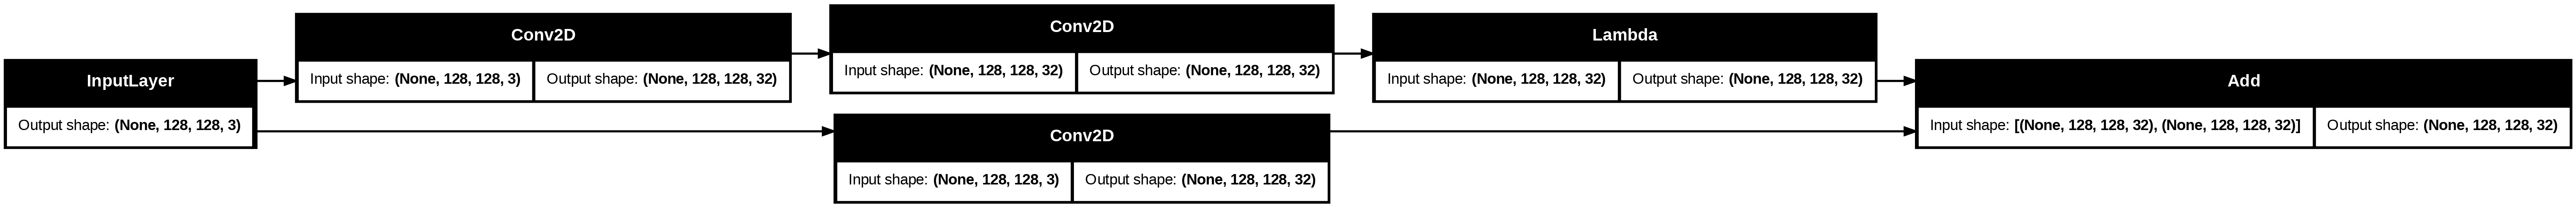

In [ ]:
plot_model(model_resid_block, show_shapes=True, show_layer_names=False, rankdir='LR')

In [ ]:
# let's try to visualize the feature map from an input image

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/'

im_path = path + 'My-Cat.jpg'

img = tf.keras.preprocessing.image.load_img(im_path, target_size=(128, 128))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array/255.0
print (img_array.shape)

(128, 128, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


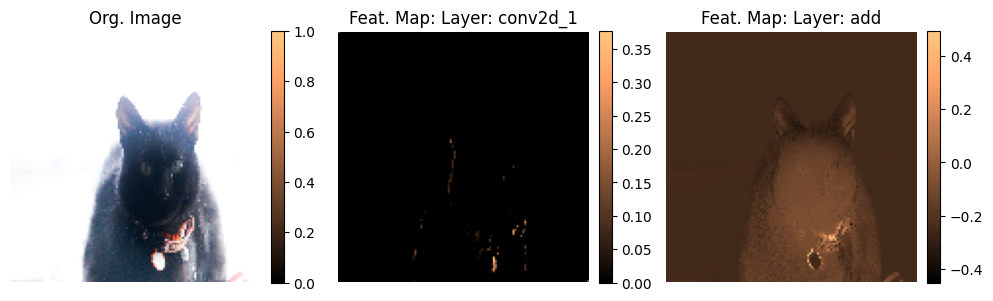

In [ ]:
def plot_feat_maps(model, input_image, layer_names:list):
  '''
  plot feature maps given a layer:
  we can get the layer names from model summary
  '''

  output_layer1 = model.get_layer(layer_names[0])
  output_layer2 = model.get_layer(layer_names[1])

  sub_model1 = tf.keras.Model(inputs=model.inputs, outputs=output_layer1.output)
  sub_model2 = tf.keras.Model(inputs=model.inputs, outputs=output_layer2.output)

  img_batch = input_image[np.newaxis, ...]

  feature_maps1 = sub_model1.predict(img_batch)
  feature_maps2 = sub_model2.predict(img_batch)

  fig = plt.figure(figsize=(12, 6))

  plt.subplot(131)
  plt.imshow(input_image, cmap='copper')
  plt.title('Org. Image')
  plt.colorbar(fraction=0.046, pad=0.04)
  plt.axis('off')

  plt.subplot(132)
  plt.imshow(feature_maps1[0, :, :, 0], cmap='copper')
  plt.colorbar(fraction=0.046, pad=0.04)
  plt.title('Feat. Map: Layer: %s'%(layer_names[0]))
  plt.axis('off')

  plt.subplot(133)
  plt.imshow(feature_maps2[0, :, :, 0], cmap='copper')
  plt.title('Feat. Map: Layer: %s'%(layer_names[1]))
  plt.colorbar(fraction=0.046, pad=0.04)
  plt.axis('off')

  plt.show()



plot_feat_maps(model_resid_block, img_array, layer_names=['conv2d_1', 'add'])




In [ ]:
### Create a Resdiual Dense Block

def RDB_simple(x_in, growth_channels=32, convs_per_block=3,
                       name_prefix="rdb", residual_scale=0.2):
    inputs = [x_in]

    for i in range(convs_per_block):
        x = Concatenate()(inputs)
        x = Conv2D(growth_channels, kernel_size=3, padding='same',
                   name=f"{name_prefix}_conv{i+1}", activation='relu')(x)
        # conv with relu activation
        inputs.append(x)

    x_concat = Concatenate()(inputs[1:])  # skip x_in
    fused = Conv2D(x_in.shape[-1], kernel_size=3, padding='same',
                   name=f"{name_prefix}_conv_fuse")(x_concat)
    # activation None; raw output from Conv

    # apply residual scaling inside the RDB
    fused = tf.keras.layers.Lambda(lambda t: t * residual_scale)(fused)

    out = Add()([x_in, fused])
    return out



input_shape = (128, 128, 3)
input_im = Input(shape=input_shape)
output_tensor_rdb = RDB_simple(input_im, 32, convs_per_block=3, name_prefix='rdb_simple', residual_scale=0.2)

model_rdb = tf.keras.Model(inputs=input_im, outputs = output_tensor_rdb)
model_rdb.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rdb_simple_conv1    │ (None, 128, 128,  │        896 │ concatenate[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 35)               │            │ rdb_simple_conv1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rdb_simple_conv2    │ (None, 128, 128,  │     10,112 │ concatenate_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 67)               │            │ rdb_simple_conv1… │
│                     │                   │            │ rdb_simple_conv2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rdb_simple_conv3    │ (None, 128, 128,  │     19,328 │ concatenate_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ rdb_simple_conv1… │
│ (Concatenate)       │ 96)               │            │ rdb_simple_conv2… │
│                     │                   │            │ rdb_simple_conv3… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rdb_simple_conv_fu… │ (None, 128, 128,  │      2,595 │ concatenate_3[0]… │
│ (Conv2D)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ rdb_simple_conv_… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,931 (128.64 KB)

 Trainable params: 32,931 (128.64 KB)

 Non-trainable params: 0 (0.00 B)

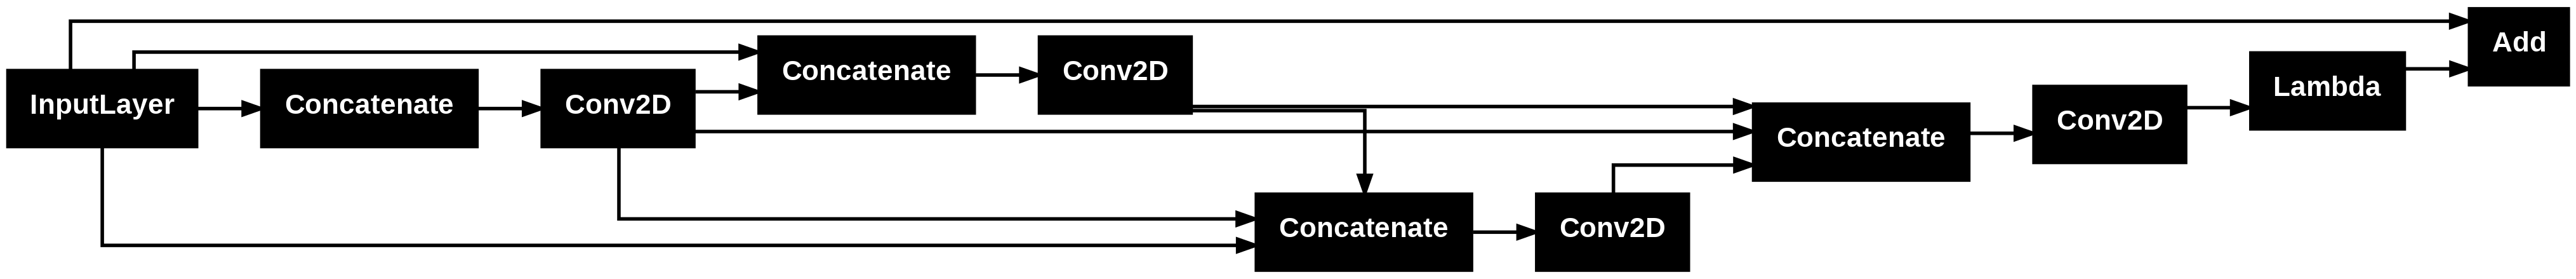

In [ ]:
plot_model(model_rdb, show_shapes=False, show_layer_names=False, rankdir='LR')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_8']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


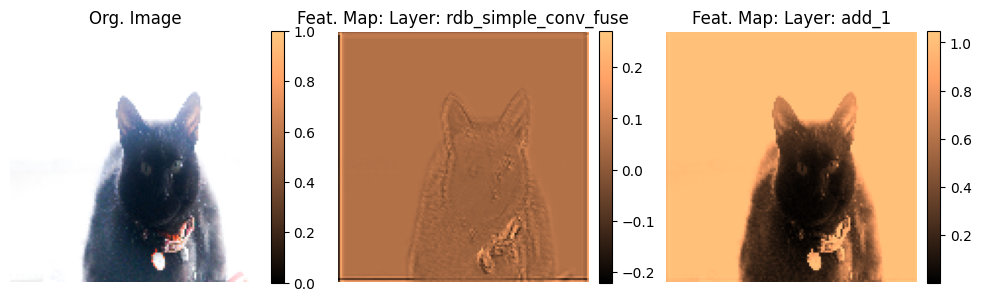

In [ ]:
plot_feat_maps(model_rdb, img_array, layer_names=['rdb_simple_conv_fuse', 'add_1'])

In [ ]:
### using the RDB create a RRDB

def RRDB(x_in, growth_channels=32, convs_per_block=3,
         name_prefix="rrdb", residual_scale=0.2):
    x = x_in
    for i in range(2):  # two RDBs inside
        x = RDB_simple(x, growth_channels=growth_channels,
                       convs_per_block=convs_per_block,
                       name_prefix=f"{name_prefix}_rdb{i+1}",
                       residual_scale=residual_scale)  # Pass it here too

    x = tf.keras.layers.Lambda(lambda t: t * residual_scale)(x)
    out = Add()([x_in, x])
    return out


input_shape = (128, 128, 3)
input_im = Input(shape=input_shape)
output_tensor_rrdb_mod = RRDB(input_im, 32, convs_per_block=3, name_prefix='rrdb', residual_scale=0.2)

model_rrdb_mod = tf.keras.Model(inputs=input_im, outputs = output_tensor_rrdb_mod)
model_rrdb_mod.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Concatenate)       │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_rdb1_conv1     │ (None, 128, 128,  │        896 │ concatenate_4[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Concatenate)       │ 35)               │            │ rrdb_rdb1_conv1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_rdb1_conv2     │ (None, 128, 128,  │     10,112 │ concatenate_5[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Concatenate)       │ 67)               │            │ rrdb_rdb1_conv1[… │
│                     │                   │            │ rrdb_rdb1_conv2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_rdb1_conv3     │ (None, 128, 128,  │     19,328 │ concatenate_6[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 128, 128,  │          0 │ rrdb_rdb1_conv1[… │
│ (Concatenate)       │ 96)               │            │ rrdb_rdb1_conv2[… │
│                     │                   │            │ rrdb_rdb1_conv3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_rdb1_conv_fuse │ (None, 128, 128,  │      2,595 │ concatenate_7[0]… │
│ (Conv2D)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128, 128,  │          0 │ rrdb_rdb1_conv_f… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 128, 128,  │          0 │ add_2[0][0]       │
│ (Concatenate)       │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_rdb2_conv1     │ (None, 128, 128,  │        896 │ concatenate_8[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 128, 128,  │          0 │ add_2[0][0],      │
│ (Concatenate)       │ 35)               │            │ rrdb_rdb2_conv1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rrdb_rdb2_conv2     │ (None, 128, 128,  │     10,112 │ concatenate_9[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 128, 128,  │          0 │ add_2[0][0],      │
│ (Concatenate)       │ 67)               │            │ rrdb_rdb2_conv1[

 Total params: 65,862 (257.27 KB)

 Trainable params: 65,862 (257.27 KB)

 Non-trainable params: 0 (0.00 B)

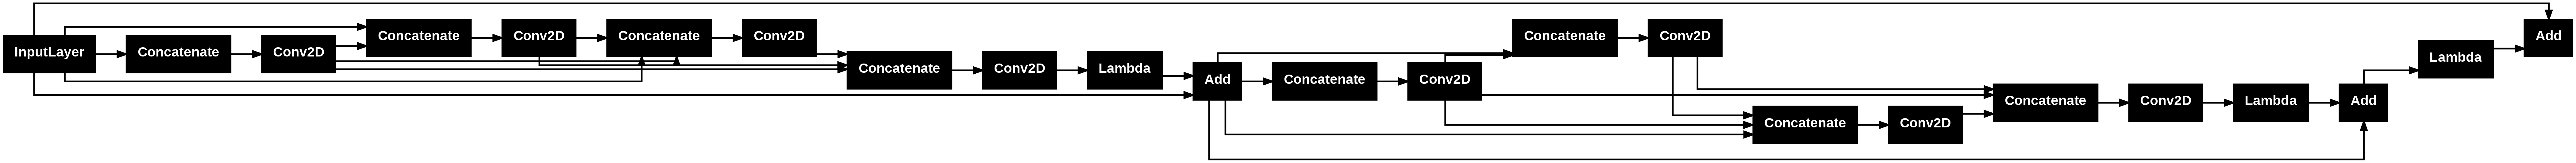

In [ ]:
plot_model(model_rrdb_mod, show_shapes=False, show_layer_names=False, rankdir='LR')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_21']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


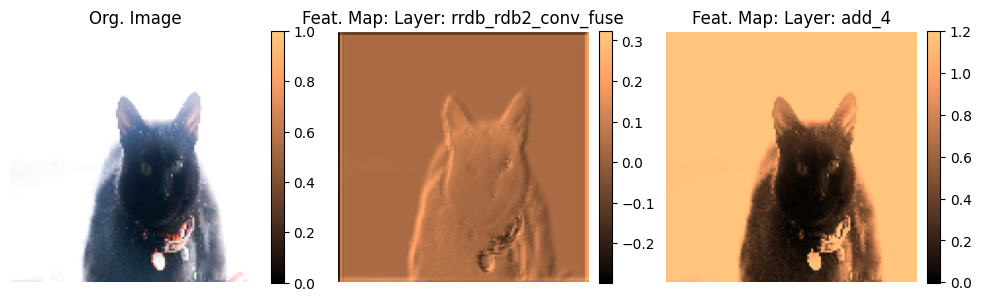

In [ ]:
plot_feat_maps(model_rrdb_mod, img_array, layer_names=['rrdb_rdb2_conv_fuse', 'add_4'])